Description: Here I use Python to access the Google Earth Engine API and explore how Iowa's cropland has changed between 2003 and 2022.

![](images/iowa-crops.png)

## Introduction: 

Iowa is an agriculture state. It is a major hub for corn and soy. In fact, my great-grandparents used to farm Iowa land. So how has Iowa's cropland changed over time? Here I begin exploring that question using remote sensing products accessed through Google Earth Engine.

## The Data: 

I use the Cropland Data Layer created by the USDA, National Agricultural Statistics Service (NASS), Research and Development Division, Geospatial Information Branch, Spatial Analysis Research Section^1^. This dataset has been reported annually since 1997, but 2003 is the first year where coverage accross Iowa is complete. I use 2003 and 2022 in my explorations. I also use the FAO GAUL: Global Administrative Unit Layers 2015, First-Level Administrative Units to clip the cropland data to the state of Iowa^2^.

## Methods & Results:

I start by importing all necessary libraries/modules and reading in all data. I use *ee* for accessing the Google Earth Engine data, and *geemap* for mapping the rasters. *NumpPy* and *Pandas* are for handling tabular data. *Matplotlib* is used to visualize results.

In [1]:
#| warning: false
# Import necessary packages
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyleaflet

# Authenticate and initialize Google Earth Engine
#ee.Authenticate()
ee.Initialize()

I read in the administrative boundary data and filter for the US and Iowa.

In [2]:
#| warning: false
# Read in boundary gee data
boundaries = ee.FeatureCollection("FAO/GAUL/2015/level1") 
# Apply the filter to get Iowa
iowa = boundaries.filter(ee.Filter.eq("ADM0_NAME", "United States of America")) \
    .filter(ee.Filter.eq("ADM1_NAME", "Iowa"))

I read in the crop data, filter for my years of interest and clip to the state of iowa.

In [3]:
#| warning: false
# Read in crop data from gee
crop_dat = ee.ImageCollection("USDA/NASS/CDL") 
crop_vis = {'bands': ['cropland']}

# Read in crop data from GEE for the year 2003
cropland_03 = crop_dat \
    .filterDate('2003') \
    .first() \
    .clip(iowa)

# Read in crop data from GEE for the year 2022
cropland_22 = crop_dat \
    .filterDate('2022') \
    .first() \
    .clip(iowa)

Let's explore the cropland use in Iowa in 2003.

In [4]:
#| warning: false
# Create a map
Map_03 = geemap.Map()

# Change basemap
Map_03.add_basemap('SATELLITE')

# Add iowa and center/zoom
Map_03.addLayer(iowa)
Map_03.centerObject(iowa, 6)

# Add your raster data to the map
Map_03.addLayer(cropland_03, crop_vis, 'Landcover')
Map_03.add_legend(title="USDA Land and Crop Classification", builtin_legend='USDA/NASS/CDL')

# Display the map
display(Map_03)

Map(center=[42.075160654145094, -93.49593105615148], controls=(WidgetControl(options=['position', 'transparent…

::: {.callout-note}
Quarto does not seem to consistently render GEE maps. This is something I am still trouble-shooting. Because of this, I have included pictures of the outputs, and a [link to the Jupyter Notebook.](https://github.com/elkewind/misc-code-examples/blob/main/exploring-cropland-gee.ipynb)
:::

![](images/crops_03.png)

Let's explore the cropland use in Iowa in 2022.

In [5]:
# Create a map
Map_22 = geemap.Map()

# Change basemap
Map_22.add_basemap('SATELLITE')

# Add iowa and center/zoom
Map_22.addLayer(iowa)
Map_22.centerObject(iowa, 6)

# Add your raster data to the map
Map_22.addLayer(cropland_22, crop_vis, 'Landcover')
Map_22.add_legend(title="USDA Land and Crop Classification", builtin_legend='USDA/NASS/CDL')

# Display the map
display(Map_22)

Map(center=[42.075160654145094, -93.49593105615148], controls=(WidgetControl(options=['position', 'transparent…

![](images/crops_22.png)

I used the image_area_by_group function from geepmap to calculate the area of each type of crop in each year. Now I have tabular data I can work with as well.

In [6]:
#| warning: false
# Reduce for image_area_by_group to work properly
reduced_03 = crop_dat.select('cropland').filterDate('2003').reduce(ee.Reducer.mode()).clip(iowa)
reduced_22 = crop_dat.select('cropland').filterDate('2022').reduce(ee.Reducer.mode()).clip(iowa)
# Calculate square km of each group for each year and create dataframe
areas_03 = geemap.image_area_by_group(reduced_03, scale=1000, denominator=1e6,decimal_places=4, verbose=False)
areas_22 = geemap.image_area_by_group(reduced_22, scale=1000, denominator=1e6,decimal_places=4, verbose=False)

I also create a dataframe of the specified legend colors designated by the USDA.

In [7]:
#| warning: false
#| code-fold: true
# Create dictionary of colors so we can use them in vis later (I don't think I can extract from built-in colors)
legend_dict = {
    '1 Corn': '#ffd300',
    '2 Cotton': '#ff2626',
    '3 Rice': '#00a8e2',
    '4 Sorghum': '#ff9e0a',
    '5 Soybeans': '#267000',
    '6 Sunflower': '#ffff00',
    '10 Peanuts': '#70a500',
    '11 Tobacco': '#00af49',
    '12 Sweet Corn': '#dda50a',
    '13 Pop or Orn Corn': '#dda50a',
    '14 Mint': '#7cd3ff',
    '21 Barley': '#e2007c',
    '22 Durum Wheat': '#896054',
    '23 Spring Wheat': '#d8b56b',
    '24 Winter Wheat': '#a57000',
    '25 Other Small Grains': '#d69ebc',
    '26 Dbl Crop WinWht/Soybeans': '#707000',
    '27 Rye': '#aa007c',
    '28 Oats': '#a05989',
    '29 Millet': '#700049',
    '30 Speltz': '#d69ebc',
    '31 Canola': '#d1ff00',
    '32 Flaxseed': '#7c99ff',
    '33 Safflower': '#d6d600',
    '34 Rape Seed': '#d1ff00',
    '35 Mustard': '#00af49',
    '36 Alfalfa': '#ffa5e2',
    '37 Other Hay/Non Alfalfa': '#a5f28c',
    '38 Camelina': '#00af49',
    '39 Buckwheat': '#d69ebc',
    '41 Sugarbeets': '#a800e2',
    '42 Dry Beans': '#a50000',
    '43 Potatoes': '#702600',
    '44 Other Crops': '#00af49',
    '45 Sugarcane': '#af7cff',
    '46 Sweet Potatoes': '#702600',
    '47 Misc Vegs & Fruits': '#ff6666',
    '48 Watermelons': '#ff6666',
    '49 Onions': '#ffcc66',
    '50 Cucumbers': '#ff6666',
    '51 Chick Peas': '#00af49',
    '52 Lentils': '#00ddaf',
    '53 Peas': '#54ff00',
    '54 Tomatoes': '#f2a377',
    '55 Caneberries': '#ff6666',
    '56 Hops': '#00af49',
    '57 Herbs': '#7cd3ff',
    '58 Clover/Wildflowers': '#e8bfff',
    '59 Sod/Grass Seed': '#afffdd',
    '60 Switchgrass': '#00af49',
    '61 Fallow/Idle Cropland': '#bfbf77',
    '63 Forest': '#93cc93',
    '64 Shrubland': '#c6d69e',
    '65 Barren': '#ccbfa3',
    '66 Cherries': '#ff00ff',
    '67 Peaches': '#ff8eaa',
    '68 Apples': '#ba004f',
    '69 Grapes': '#704489',
    '70 Christmas Trees': '#007777',
    '71 Other Tree Crops': '#af9970',
    '72 Citrus': '#ffff7c',
    '74 Pecans': '#b5705b',
    '75 Almonds': '#00a582',
    '76 Walnuts': '#e8d6af',
    '77 Pears': '#af9970',
    '81 Clouds/No Data': '#f2f2f2',
    '82 Developed': '#999999',
    '83 Water': '#4970a3',
    '87 Wetlands': '#7cafaf',
    '88 Nonag/Undefined': '#e8ffbf',
    '92 Aquaculture': '#00ffff',
    '111 Open Water': '#4970a3',
    '112 Perennial Ice/Snow': '#d3e2f9',
    '121 Developed/Open Space': '#999999',
    '122 Developed/Low Intensity': '#999999',
    '123 Developed/Med Intensity': '#999999',
    '124 Developed/High Intensity': '#999999',
    '131 Barren': '#ccbfa3',
    '141 Deciduous Forest': '#93cc93',
    '142 Evergreen Forest': '#93cc93',
    '143 Mixed Forest': '#93cc93',
    '152 Shrubland': '#c6d69e',
    '176 Grassland/Pasture': '#e8ffbf',
    '190 Woody Wetlands': '#7cafaf',
    '195 Herbaceous Wetlands': '#7cafaf',
    '204 Pistachios': '#00ff8c',
    '205 Triticale': '#d69ebc',
    '206 Carrots': '#ff6666',
    '207 Asparagus': '#ff6666',
    '208 Garlic': '#ff6666',
    '209 Cantaloupes': '#ff6666',
    '210 Prunes': '#ff8eaa',
    '211 Olives': '#334933',
    '212 Oranges': '#e27026',
    '213 Honeydew Melons': '#ff6666',
    '214 Broccoli': '#ff6666',
    '215 Avocados': '#739755',
    '216 Peppers': '#ff6666',
    '217 Pomegranates': '#af9970',
    '218 Nectarines': '#ff8eaa',
    '219 Greens': '#ff6666',
    '220 Plums': '#ff8eaa',
    '221 Strawberries': '#ff6666',
    '222 Squash': '#ff6666',
    '223 Apricots': '#ff8eaa',
    '224 Vetch': '#00af49',
    '225 Dbl Crop WinWht/Corn': '#ffd300',
    '226 Dbl Crop Oats/Corn': '#ffd300',
    '227 Lettuce': '#ff6666',
    '228 Dbl Crop Triticale/Corn': '#f8d248',
    '229 Pumpkins': '#ff6666',
    '230 Dbl Crop Lettuce/Durum Wht': '#896054',
    '231 Dbl Crop Lettuce/Cantaloupe': '#ff6666',
    '232 Dbl Crop Lettuce/Cotton': '#ff2626',
    '233 Dbl Crop Lettuce/Barley': '#e2007c',
    '234 Dbl Crop Durum Wht/Sorghum': '#ff9e0a',
    '235 Dbl Crop Barley/Sorghum': '#ff9e0a',
    '236 Dbl Crop WinWht/Sorghum': '#a57000',
    '237 Dbl Crop Barley/Corn': '#ffd300',
    '238 Dbl Crop WinWht/Cotton': '#a57000',
    '239 Dbl Crop Soybeans/Cotton': '#267000',
    '240 Dbl Crop Soybeans/Oats': '#267000',
    '241 Dbl Crop Corn/Soybeans': '#ffd300',
    '242 Blueberries': '#000099',
    '243 Cabbage': '#ff6666',
    '244 Cauliflower': '#ff6666',
    '245 Celery': '#ff6666',
    '246 Radishes': '#ff6666',
    '247 Turnips': '#ff6666',
    '248 Eggplants': '#ff6666',
    '249 Gourds': '#ff6666',
    '250 Cranberries': '#ff6666',
    '254 Dbl Crop Barley/Soybeans': '#267000'
}

# Create a DataFrame from the legend dictionary
legend_df = pd.DataFrame(list(legend_dict.items()), columns=['num_crop', 'color'])
legend_df['crop'] = legend_df['num_crop'].apply(lambda x: x.split(' ', 1)[1])
legend_df['group'] = legend_df['num_crop'].apply(lambda x: x.split(' ', 1)[0])
legend_df

,num_crop,color,crop,group
0,1 Corn,#ffd300,Corn,1
1,2 Cotton,#ff2626,Cotton,2
2,3 Rice,#00a8e2,Rice,3
3,4 Sorghum,#ff9e0a,Sorghum,4
4,5 Soybeans,#267000,Soybeans,5
...,...,...,...,...
128,247 Turnips,#ff6666,Turnips,247
129,248 Eggplants,#ff6666,Eggplants,248
130,249 Gourds,#ff6666,Gourds,249
131,250 Cranberries,#ff6666,Cranberries,250


I join the color data to the area data for consistent color use when plotting.

In [8]:
#| warning: false
# Reset the index of the areas DataFrame
areas_03.reset_index(inplace=True)

# Merge the existing DataFrame with the legend DataFrame based on the 'group' column & sort
crop_areas_03 = pd.merge(areas_03, legend_df, on='group', how='left')
crop_areas_03['year'] = 2003
area_sorted_03 = crop_areas_03.sort_values(by='area', ascending=False)

# Reset the index of the areas DataFrame
areas_22.reset_index(inplace=True)

# Merge the existing DataFrame with the legend DataFrame based on the 'group' column & sort
crop_areas_22 = pd.merge(areas_22, legend_df, on='group', how='left')
crop_areas_22['year'] = 2022
area_sorted_22 = crop_areas_22.sort_values(by='area', ascending=False)

Let's check out the top 10 crops each year by area

In [9]:
#| warning: false
area_sorted_03.head(10)

,group,area,percentage,num_crop,color,crop,year
0,1,52415.6902,0.3599,1 Corn,#ffd300,Corn,2003
13,176,42853.8696,0.2942,176 Grassland/Pasture,#e8ffbf,Grassland/Pasture,2003
1,5,41927.8154,0.2879,5 Soybeans,#267000,Soybeans,2003
7,61,2933.1871,0.0201,61 Fallow/Idle Cropland,#bfbf77,Fallow/Idle Cropland,2003
8,63,1673.6551,0.0115,63 Forest,#93cc93,Forest,2003
4,36,1472.0163,0.0101,36 Alfalfa,#ffa5e2,Alfalfa,2003
10,82,1370.3573,0.0094,82 Developed,#999999,Developed,2003
11,83,478.8680,0.0033,83 Water,#4970a3,Water,2003
2,25,218.6646,0.0015,25 Other Small Grains,#d69ebc,Other Small Grains,2003
9,81,186.8087,0.0013,81 Clouds/No Data,#f2f2f2,Clouds/No Data,2003


In [10]:
#| warning: false
area_sorted_22.head(10)

,group,area,percentage,num_crop,color,crop,year
0,1,57108.8402,0.3918,1 Corn,#ffd300,Corn,2022
1,5,43917.2096,0.3013,5 Soybeans,#267000,Soybeans,2022
25,176,25775.1745,0.1769,176 Grassland/Pasture,#e8ffbf,Grassland/Pasture,2022
22,141,10638.4229,0.0730,141 Deciduous Forest,#93cc93,Deciduous Forest,2022
18,122,1590.3012,0.0109,122 Developed/Low Intensity,#999999,Developed/Low Intensity,2022
26,190,1503.0166,0.0103,190 Woody Wetlands,#7cafaf,Woody Wetlands,2022
16,111,1291.7266,0.0089,111 Open Water,#4970a3,Open Water,2022
17,121,999.4524,0.0069,121 Developed/Open Space,#999999,Developed/Open Space,2022
19,123,901.4150,0.0062,123 Developed/Med Intensity,#999999,Developed/Med Intensity,2022
27,195,759.0405,0.0052,195 Herbaceous Wetlands,#7cafaf,Herbaceous Wetlands,2022


Let's plot corn, soybean, and grassland/pasture to see how their area's have changed over the 20 years.

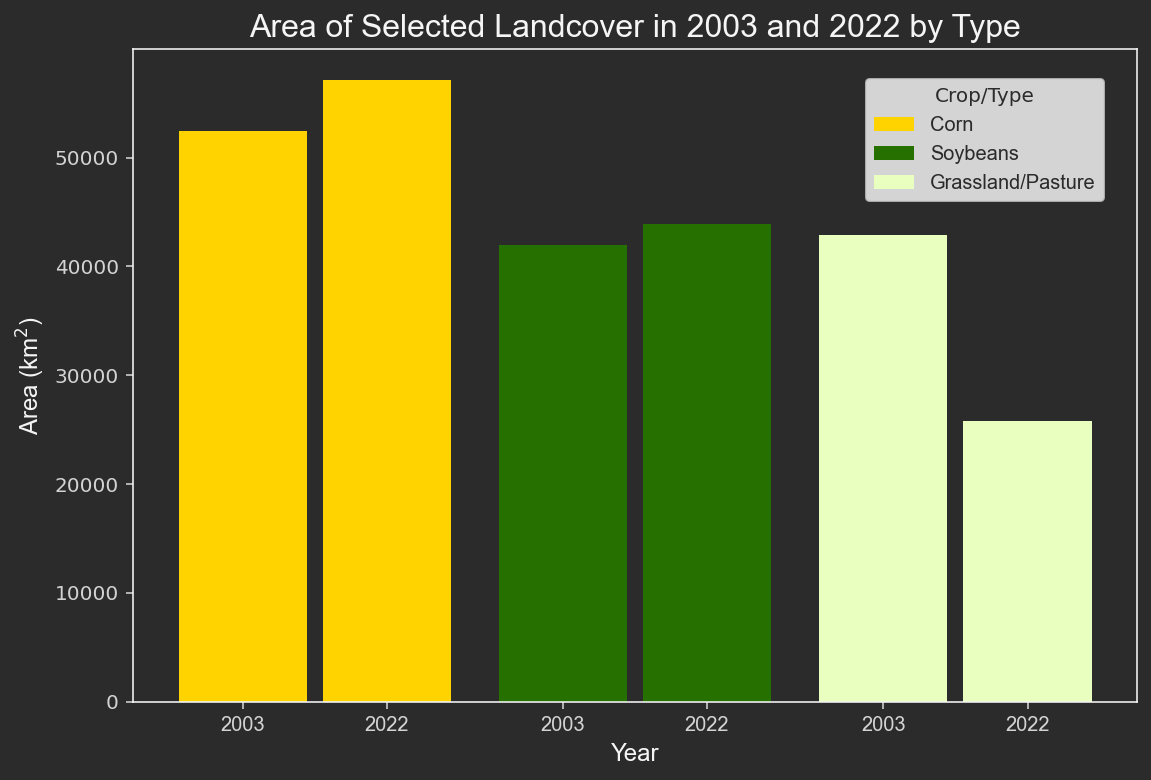

In [11]:
#| warning: false
# Create a grouped bar plot
plt.figure(figsize=(9, 6))

# Define colors
lightgray = '#f5f5f5'
darkgray = '#2b2b2b'

# Define crops/landcover of interest
selected_crops = ['Corn', 'Soybeans', 'Grassland/Pasture']

# Set bar choices
bar_width = 0.4
bar_positions_2003 = np.arange(len(selected_crops))
bar_positions_2022 = bar_positions_2003 + bar_width + 0.05

# Plot bars for 2003
for i, crop in enumerate(selected_crops):
    crop_data_2003 = area_sorted_03[(area_sorted_03['crop'] == crop) & (area_sorted_03['year'] == 2003)]
    plt.bar(bar_positions_2003[i], crop_data_2003['area'].values[0], width=bar_width, color=crop_data_2003['color'].values[0], label=crop)

# Plot bars for 2022
for i, crop in enumerate(selected_crops):
    crop_data_2022 = area_sorted_22[(area_sorted_22['crop'] == crop) & (area_sorted_22['year'] == 2022)]
    plt.bar(bar_positions_2022[i], crop_data_2022['area'].values[0], width=bar_width, color=crop_data_2022['color'].values[0])

# Set background color
plt.gca().set_facecolor(darkgray)
fig = plt.gcf()
fig.patch.set_facecolor(darkgray)

# Set labels and their aesthetics
plt.xlabel('Year', fontname='Arial', color=lightgray, size = 12)
plt.ylabel('Area (km$^2$)', fontname='Arial', color=lightgray, size = 12)
plt.title('Area of Selected Landcover in 2003 and 2022 by Type', fontname='Arial', color=lightgray, size=16)

# Adjust x-axis ticks to include both years
plt.xticks(np.concatenate([bar_positions_2003, bar_positions_2022]), [2003, 2003, 2003, 2022, 2022, 2022], fontname='Arial', color=lightgray)
plt.yticks(color=lightgray)

# Set border color
plt.gca().spines['bottom'].set_color(lightgray)
plt.gca().spines['top'].set_color(lightgray)
plt.gca().spines['right'].set_color(lightgray)
plt.gca().spines['left'].set_color(lightgray)

# Set tick marks color
plt.tick_params(axis='both', colors='lightgray')

# Set legend text color
legend = plt.legend(title='Crop/Type', bbox_to_anchor=(.72, .97), loc='upper left', prop={'family': 'Arial'})
plt.setp(legend.get_title(), color=darkgray)
for text in legend.get_texts():
    text.set_color(darkgray)

plt.show()

# Conclusions
Unsurprisingly, Iowa's land cover has changed a bit over the years, but corn remains the predominant crop. Google Earth Engine allowed me to smoothly access, use, and visualize a remote sensing data product. Further analyses could be completed to identify changes in crops through all years or what landcover type has had the largest % change over time.

## References:

^1^USDA National Agricultural Statistics Service Cropland Data Layer. 2022. Published crop-specific data layer [Online]. Available at https://nassgeodata.gmu.edu/CropScape/ (accessed 12/03/2023). USDA-NASS, Washington, DC.

^2^FAO GAUL: Global Administrative Unit Layers 2015, First-Level Administrative Units. 2015. Available at https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level1#terms-of-use (accessed 12/03/2023). FAO UN, Rome, Italy.